<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/medicine_aai_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.academia.edu/2994-7065/2/1/10.20935/AcadEng7568

In [ ]:
# Cell 1: Installs & upgrades (run this first, then restart runtime)
!pip install -U --quiet \
    langchain langchain-openai langchain-community langgraph \
    kagglehub opencv-python-headless


=== Running Agent Examples ===


=== Features Output ===

The 13-bin LBP-L histogram features for 'Tr-me_0010.jpg' are as follows:

- Bin 0: 409
- Bin 21: 94
- Bin 42: 134
- Bin 64: 134
- Bin 85: 150
- Bin 106: 159
- Bin 127: 0
- Bin 149: 176
- Bin 170: 352
- Bin 191: 179
- Bin 212: 202
- Bin 234: 180
- Bin 255: 1598

These features are extracted from the image located at '/content/drive/MyDrive/datasets/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0010.jpg'.
Trained k-NN (k=3) on 5712 images from Training folder.

=== Classification Output ===

The tumor type in 'Tr-me_0010.jpg' is classified as **meningioma** using the 3-NN (Euclidean distance) method.


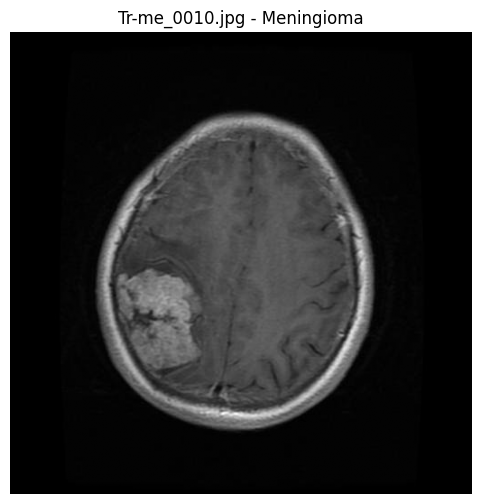

In [4]:
# =============================================================================
# FULL CORRECTED CODE – Brain MRI LBP-L Feature Extraction + k-NN Classification
# Aligned with Mishra & Meher (2025): LBP-L + 3-NN (Euclidean) on Kaggle dataset
# =============================================================================

# Run this pip line first (if not done recently), then RESTART RUNTIME
# !pip install -U --quiet langchain langchain-openai langchain-community langgraph kagglehub opencv-python-headless scikit-learn

import os
import cv2
import shutil
import numpy as np
import kagglehub
from google.colab import drive, userdata
from typing import Dict

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver

from sklearn.neighbors import KNeighborsClassifier

# ─── DRIVE & ENVIRONMENT ───
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

DEST_PATH = "/content/drive/MyDrive/datasets/brain-tumor-mri-dataset"

# ─── DATASET DOWNLOAD (if needed) ───
if not os.path.exists(DEST_PATH):
    print("Dataset missing → downloading from Kaggle...")
    temp_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    shutil.copytree(temp_path, DEST_PATH)
    print("Dataset copied to Drive.")

# ─── LBP-L FEATURE EXTRACTION ───
@tool
def extract_lbp_l_features(image_filename: str) -> Dict:
    """
    Search the brain-tumor-mri-dataset and extract 13 rotation-invariant LBP-L features.
    (Based on Mishra & Meher, 2025 – useful for Meningioma/Glioma/Pituitary classification)
    """
    target_path = None
    for root, _, files in os.walk(DEST_PATH):
        if image_filename in files:
            target_path = os.path.join(root, image_filename)
            break

    if not target_path:
        return {"error": f"File '{image_filename}' not found in dataset."}

    img = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return {"error": f"Failed to load image at {target_path}"}

    img = cv2.resize(img, (64, 64))
    rows, cols = img.shape
    lbp_l_img = np.zeros((rows, cols), np.uint8)

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            ic = img[i, j]
            neighbors = [
                img[i-1,j-1], img[i-1,j], img[i-1,j+1], img[i,j+1],
                img[i+1,j+1], img[i+1,j], img[i+1,j-1], img[i,j-1]
            ]
            bits = [1 if val >= ic else 0 for val in neighbors]
            r1 = sum(bits[k] for k in [0,2,4,6])   # diagonals
            r2 = sum(bits[k] for k in [1,3,5,7])   # axial
            lbp_l_img[i, j] = round((r1 + 2 * r2) * 21.25)

    hist, _ = np.histogram(lbp_l_img.flatten(), bins=256, range=(0, 256))
    bins = [0, 21, 42, 64, 85, 106, 127, 149, 170, 191, 212, 234, 255]
    features = {str(v): int(hist[v]) for v in bins}

    return {
        "lbp_l_features": features,
        "file_path": target_path,
        "note": "13-bin histogram counts from LBP-L (rotation-invariant)"
    }

# ─── k-NN CLASSIFIER (k=3, Euclidean) ───
knn_model = None
class_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
reverse_map = {v: k for k, v in class_map.items()}

def train_knn_once():
    global knn_model
    if knn_model is not None:
        return

    training_path = os.path.join(DEST_PATH, "Training")
    if not os.path.exists(training_path):
        raise ValueError("Training folder not found.")

    X, y = [], []

    for class_folder, label in class_map.items():
        class_dir = os.path.join(training_path, class_folder)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_folder} folder not found.")
            continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(class_dir, filename)
                img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (64, 64))
                rows, cols = img.shape
                lbp_l_img = np.zeros((rows, cols), np.uint8)

                for i in range(1, rows-1):
                    for j in range(1, cols-1):
                        ic = img[i, j]
                        neighbors = [
                            img[i-1,j-1], img[i-1,j], img[i-1,j+1], img[i,j+1],
                            img[i+1,j+1], img[i+1,j], img[i+1,j-1], img[i,j-1]
                        ]
                        bits = [1 if val >= ic else 0 for val in neighbors]
                        r1 = sum(bits[k] for k in [0,2,4,6])
                        r2 = sum(bits[k] for k in [1,3,5,7])
                        lbp_l_img[i, j] = round((r1 + 2 * r2) * 21.25)

                hist, _ = np.histogram(lbp_l_img.flatten(), bins=256, range=(0, 256))
                features_vec = np.array([hist[v] for v in [0,21,42,64,85,106,127,149,170,191,212,234,255]])
                X.append(features_vec)
                y.append(label)

    if not X:
        raise ValueError("No training images loaded.")

    X = np.array(X)
    y = np.array(y)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    knn_model.fit(X, y)
    print(f"Trained k-NN (k=3) on {len(X)} images from Training folder.")

@tool
def classify_with_knn(image_filename: str) -> Dict:
    """
    Extract LBP-L features and classify tumor type using 3-NN (Euclidean distance)
    as described in Mishra & Meher (2025). Returns predicted class and features.
    """
    global knn_model
    if knn_model is None:
        train_knn_once()

    # FIXED: Use .invoke() instead of direct call
    features_result = extract_lbp_l_features.invoke({"image_filename": image_filename})
    if "error" in features_result:
        return features_result

    bins = [0,21,42,64,85,106,127,149,170,191,212,234,255]
    feature_vec = np.array([features_result["lbp_l_features"][str(v)] for v in bins]).reshape(1, -1)

    pred_label = knn_model.predict(feature_vec)[0]
    pred_class = reverse_map[pred_label]

    return {
        "predicted_class": pred_class,
        "confidence_proxy": "k=3 nearest neighbors (Euclidean distance)",
        "lbp_l_features": features_result["lbp_l_features"],
        "file_path": features_result["file_path"]
    }

# ─── AGENT SETUP ───
llm = ChatOpenAI(model="gpt-4o", temperature=0)

tools = [extract_lbp_l_features, classify_with_knn]

system_prompt = SystemMessage(content="""You are a brain MRI analysis assistant using LBP-L features (Mishra & Meher, 2025).
- Use extract_lbp_l_features to get the 13-bin LBP-L histogram.
- Use classify_with_knn to predict tumor type (glioma, meningioma, pituitary, notumor) with 3-NN.
Be precise, concise and professional.""")

memory = MemorySaver()

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_prompt,
    checkpointer=memory
)

# ─── RUN EXAMPLES ───
print("\n=== Running Agent Examples ===\n")

config = {"configurable": {"thread_id": "mri_demo_20260117"}}

# Example 1: Feature extraction
query1 = "Extract LBP-L features for 'Tr-me_0010.jpg'"
result1 = agent.invoke({"messages": [HumanMessage(content=query1)]}, config=config)
print("\n=== Features Output ===\n")
print(result1["messages"][-1].content)

# Example 2: Classification (trains k-NN automatically on first call)
query2 = "Classify the tumor type in 'Tr-me_0010.jpg'"
result2 = agent.invoke({"messages": [HumanMessage(content=query2)]}, config=config)
print("\n=== Classification Output ===\n")
print(result2["messages"][-1].content)

# Optional: Show the image
import matplotlib.pyplot as plt
img_path = os.path.join(DEST_PATH, "Training/meningioma/Tr-me_0010.jpg")
if os.path.exists(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title("Tr-me_0010.jpg - Meningioma")
    plt.axis('off')
    plt.show()